In [35]:
import logging
from pathlib import Path
import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL.ImageDraw import Draw

from anipaint import find_edge_distance, find_directions, cached_edge_distance, composite, paint_edge

shared_datadir = Path(r"D:\OneDrive\programs\anipaint\anipaint\tests\data")
tmp_path = Path(r"m:/deldir/anipaint/tests")

logging.basicConfig(level=logging.INFO)
plt.rcParams['figure.figsize'] = [12, 8]

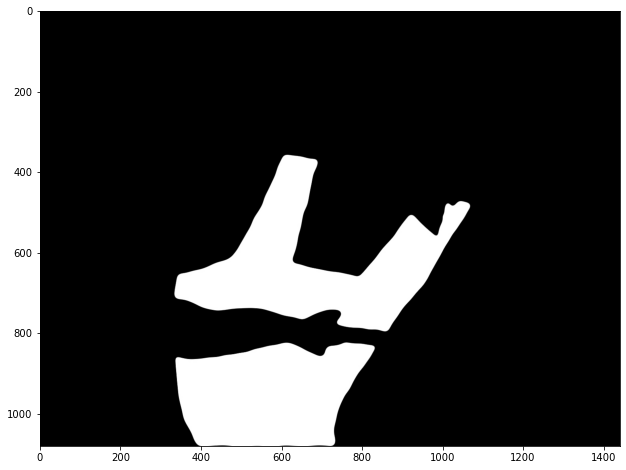

In [2]:
# open a matte
matte_file = "Comp 2/ShirtMAtte_00000.jpg"
matte_path = shared_datadir / matte_file
cache_path = shared_datadir / "Comp 2/cache"
matte_image = Image.open(matte_path)
plt.imshow(matte_image)
plt.show()
assert matte_image.mode == "RGB", f"Expect images to be RGB, not {matte_image.mode}"
rgb_array = np.array(matte_image)

In [19]:
# References:
#  https://stackoverflow.com/questions/48585468/vectorize-conways-game-of-life-in-pure-numpy
#  Search this more: cellular automata numpy
#  Also look at image kernels and implementing guassian, etc blur
#  Also look for libraries
#  https://datacarpentry.org/image-processing/08-edge-detection/
#  https://jessicastringham.net/2017/12/31/stride-tricks/ -- Implementing convolutions with stride_tricks
#  https://setosa.io/ev/image-kernels/


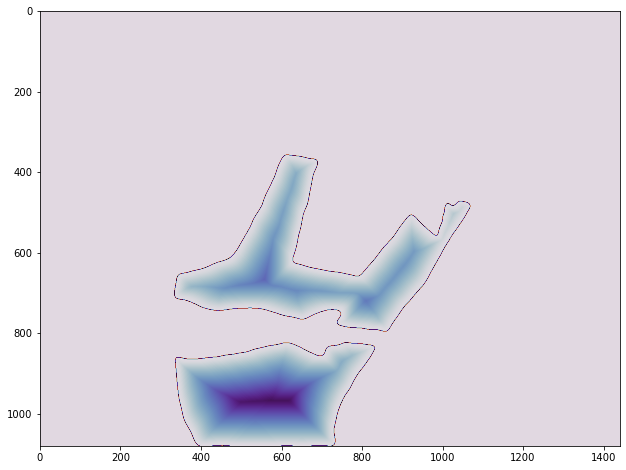

In [3]:
edge_distance = cached_edge_distance(matte_path,cache_path)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255) # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.show()

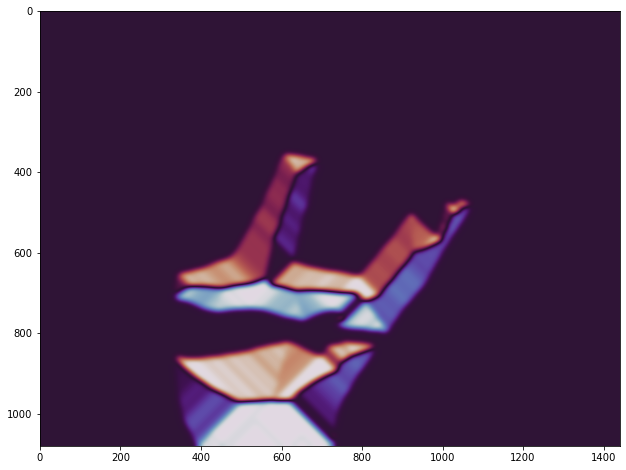

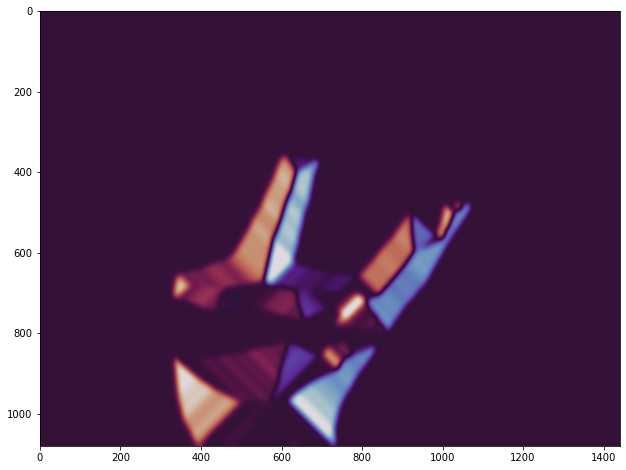

In [8]:
directions = find_directions(edge_distance)
plt.imshow(directions[0],cmap='twilight')
plt.show()
plt.imshow(directions[1],cmap='twilight')
plt.show()

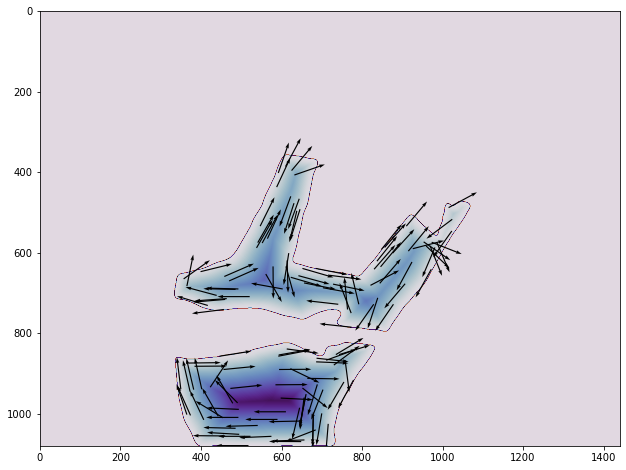

In [10]:
import math

random_count = 1000

rng = np.random.RandomState(seed=231) # random number generator
rand_x=rng.randint(0,edge_distance.shape[0],random_count)
rand_y=rng.randint(0,edge_distance.shape[1],random_count)
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for i in range(random_count):
    x,y = rand_x[i],rand_y[i]
    v = edge_distance[x,y]
    if v==0:
        continue
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    # print(x,y,v,dx,dy)
    # plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show()    

(3675,)
(array([ 386,  386,  386, ..., 1055, 1055, 1055], dtype=int64), array([627, 628, 629, ..., 572, 573, 574], dtype=int64))


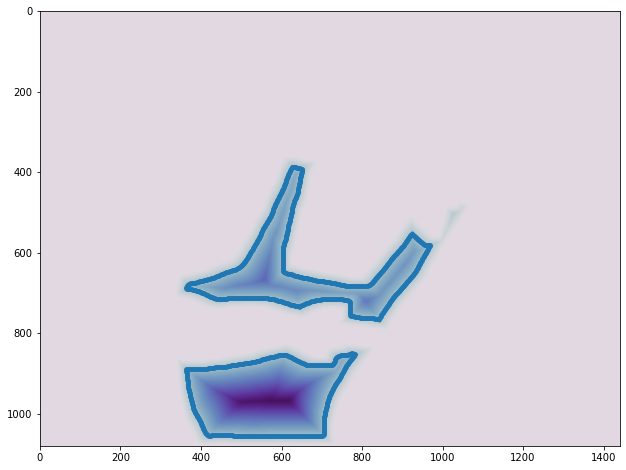

In [76]:
# Where to put next EDGE brushstroke.

how_far_in = 25 # This could be a little random and based on width of stroke

candidates = np.nonzero(edge_distance==how_far_in)
print(candidates[0].shape)
print(candidates)

plt.imshow(edge_distance,cmap='twilight', vmin=0, vmax=255)
plt.plot(candidates[1],candidates[0],".")
plt.show()

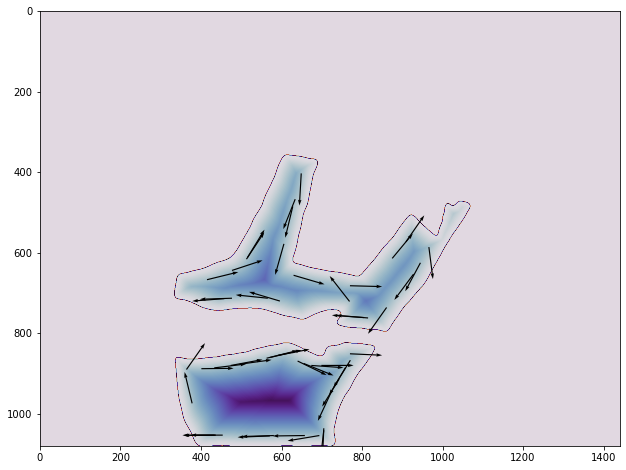

In [77]:
random_count = 50

rng = np.random.RandomState(seed=231) # random number generator
plt.imshow(np.where(edge_distance==0,256,edge_distance),cmap='twilight', vmin=0, vmax=255)
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    #print(x,y,v,dx,dy)
    #plt.plot(y,x,"o")
    plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)
plt.show() 

RGBA


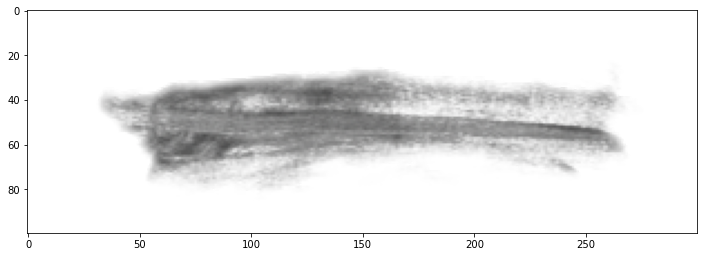

In [4]:
brush_file = "brushes/PaintStrokes (0-00-00-04).png"
brush_path = shared_datadir / brush_file
brush_image = Image.open(brush_path)
assert brush_image.mode == "RGBA", f"Expect images to be RGBA, not {brush_image.mode}"
print(brush_image.mode)
plt.imshow(brush_image)

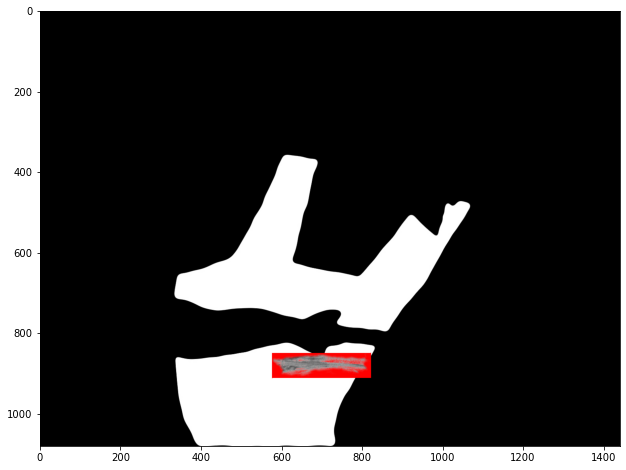

In [78]:
im1 = composite(matte_image,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=True)
plt.imshow(im1)
plt.show()

In [95]:
average_brush = int(np.array(brush_image)[:,:,0:2].mean()+.5)
print(average_brush)
count_these = ((edge_distance > 0)*(edge_distance <20))
count_these.sum()

126


81953

119.36028935185185
119.36028935185185


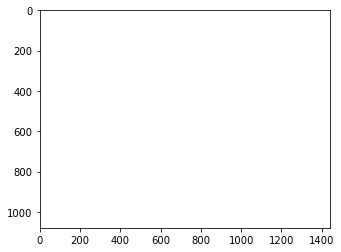

119.66300540123457
119.66300540123457


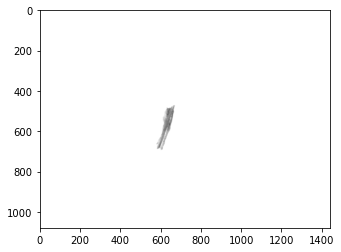

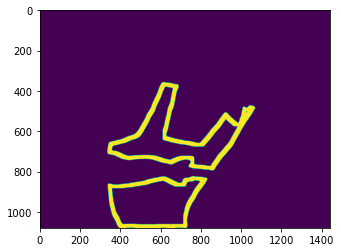

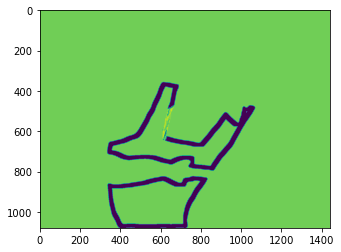

In [130]:
def how_dark(image):
    score = np.where(count_these,np.array(image)[:,:,0:-1].mean(axis=-1),average_brush).mean()
    print(score)
    return score

im1 = Image.new("RGBA", matte_image.size, (0,0,0,0))
print(how_dark(im1))
plt.imshow(im1)
plt.show()
print(how_dark(im2))
plt.imshow(im2)
plt.show()

plt.imshow(count_these)
plt.show()

wh = np.where(count_these,np.array(im2)[:,:,0:-1].mean(axis=-1),average_brush)
plt.imshow(wh)
plt.show()

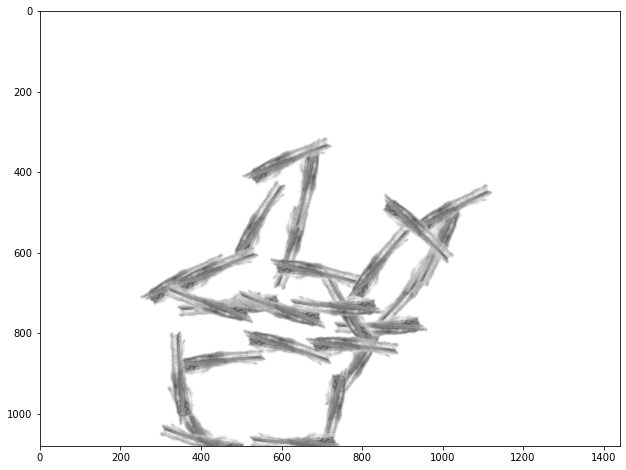

In [143]:
how_far_in = 10 # This could be a little random and based on width of stroke
random_count = 100
show_work = False
keep_threshold = .1


candidates = np.nonzero(edge_distance==how_far_in)

if show_work:
    plt.rcParams['figure.figsize'] = [6, 4]
else:    
    plt.rcParams['figure.figsize'] = [12, 8]

rng = np.random.RandomState(seed=231) # random number generator

im1 = Image.new("RGBA", matte_image.size, (0,0,0,0))
#im_alpha = Image.new("RGBA", matte_image.size, (0,0,0,0))

def how_dark(image):
    score = np.where(count_these,np.array(image)[:,:,0:-1].mean(axis=-1),average_brush).mean()
    return score


old_sum = how_dark(im1)
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    dx,dy = directions[0][x,y],directions[1][x,y]
    angle = math.atan2(dy,dx)-math.pi/2
    dxr,dyr = math.cos(angle),math.sin(angle)
    im2 = composite(im1,brush_image,y,x,-math.degrees(math.atan2(dy,dx)),sprite_factor=1,draw_debug_line=False)
    new_sum = how_dark(im2)
    diff = new_sum-old_sum
    #{old_sum:,}-{new_sum:,}=
    if show_work:
            print(f"{diff:,}")
            plt.plot(y,x,"o")
            #plt.quiver(y,x,-dyr,-dxr,angles='xy',width=.002)    
            plt.imshow(im2)
            plt.show()
    if diff > keep_threshold:
        old_sum = new_sum
        im1=im2
    elif show_work:
         print("don't keep")
#plt.imshow(im1)
im1.save(tmp_path / f"edge{how_far_in}_{random_count}_{keep_threshold}.png")
plt.imshow(im1)
plt.show()

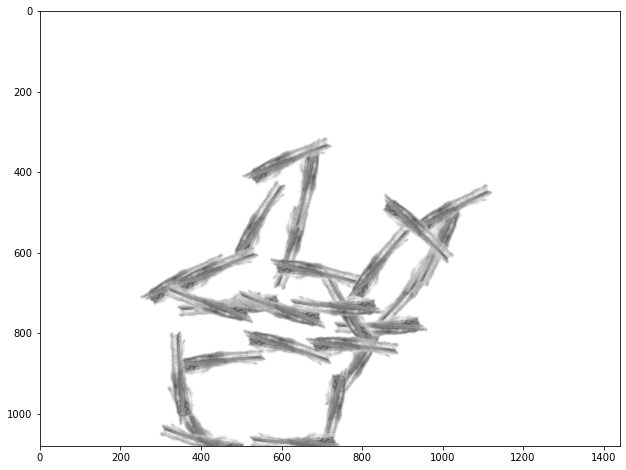

In [11]:
how_far_in = 10
random_count = 100
keep_threshold = .1

im1 = paint_edge(
    edge_distance,
    brush_image,
    how_far_in=how_far_in,
    credit_range=[1, 20],
    random_count=random_count,
    keep_threshold=keep_threshold,
)
im1.save(tmp_path / f"edge{how_far_in}_{random_count}_{keep_threshold}.png")
plt.imshow(im1)
plt.show()

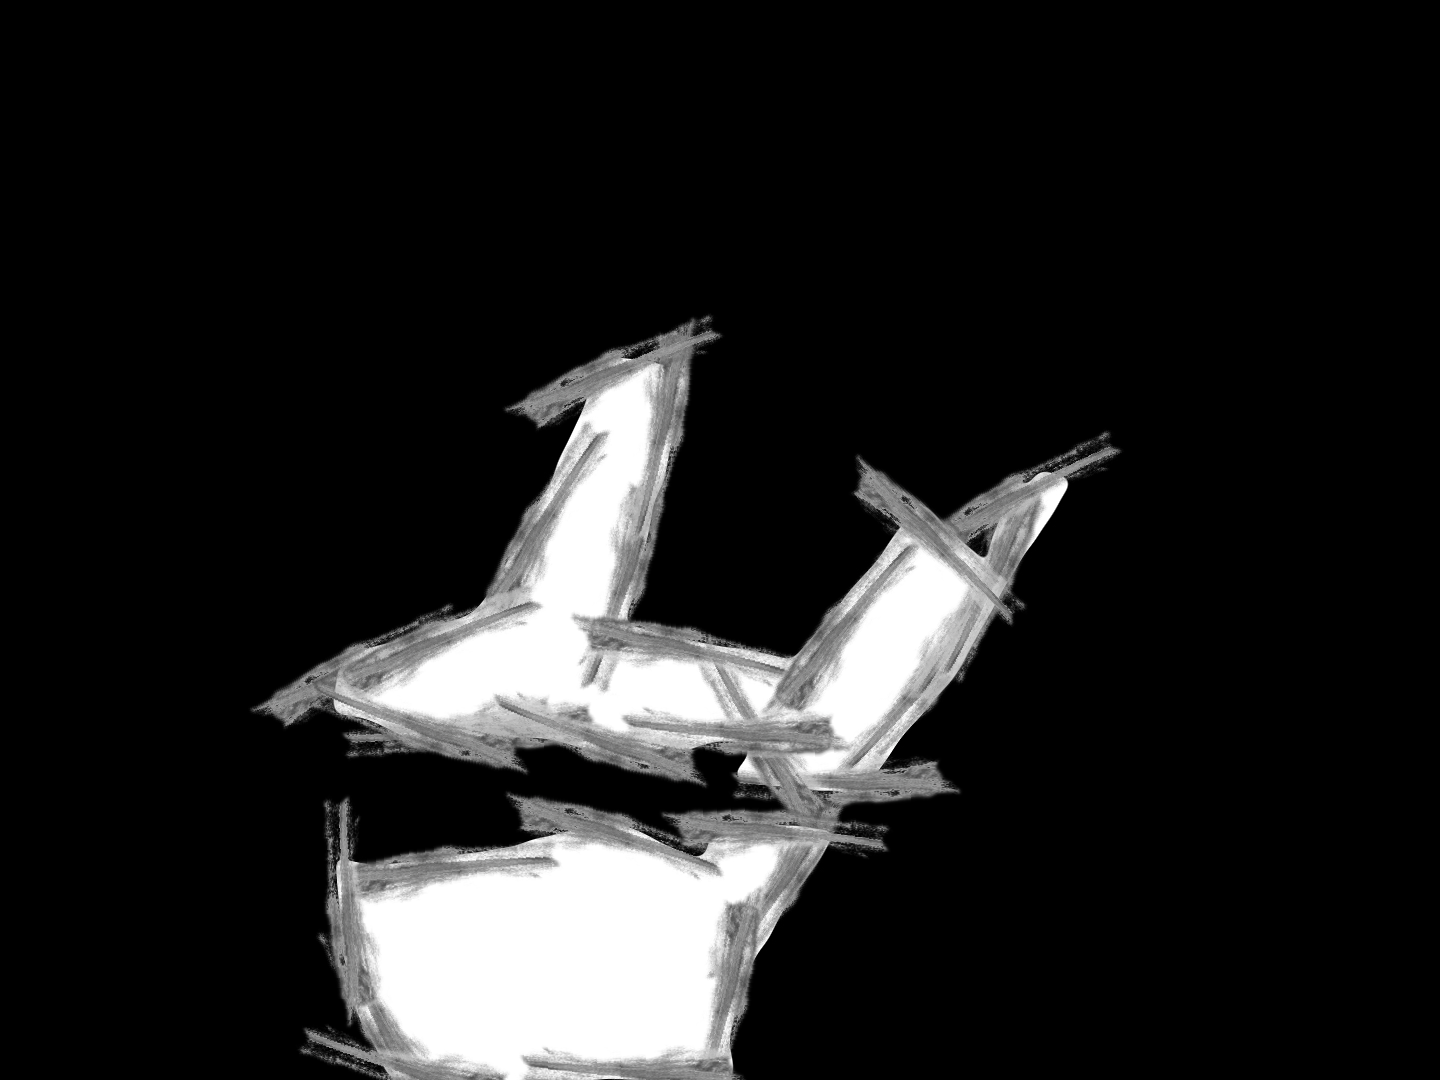

In [29]:
im3 = matte_image.copy()
im3.paste(im1,(0,0),im1)
im3.save(tmp_path / f"edgeC{how_far_in}_{random_count}_{keep_threshold}.png")
im3

In [52]:
np.unique(edge_distance,return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113], dtype=uint8),
 array([1336372,    4612,    4596,    4577,    4552,    4525,    4491,
           4464,    4435,    4405,    4376,    4343,    4302,    4235,
           4149,    4081,    4028,    3983,    3925,    3874,    3824,
           3783,    3757,    3731,    3701,    3675,    3644,    3618,
           3588,    3552,    3519,    3484,    3451,    340

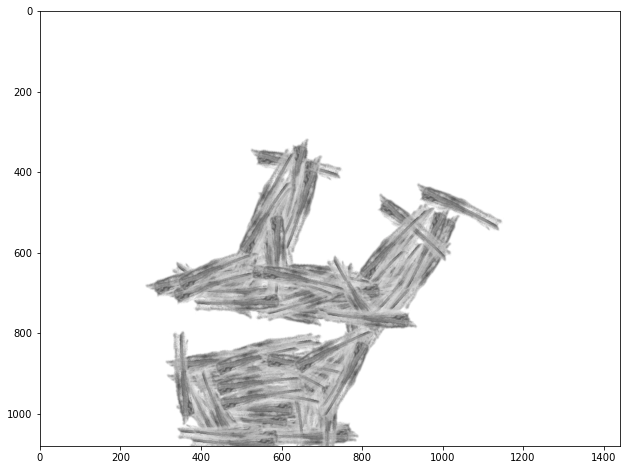

In [70]:
how_far_in = 5 # defines candidate points
random_count = 250
show_work = False
keep_threshold = .03
default_angle_degrees = 15
default_angle_sd = 5
always_use_edge_angle = 113
always_use_default_angle = 114
sprite_factor = 1

average_brush = int(np.array(brush_image)[:,:,0:2].mean()+.5)
count_these = edge_distance >=how_far_in
directions = find_directions(edge_distance)

candidates = np.nonzero(edge_distance>=how_far_in)

if show_work:
    plt.rcParams['figure.figsize'] = [6, 4]
else:    
    plt.rcParams['figure.figsize'] = [12, 8]

rng = np.random.RandomState(seed=231) # random number generator

im_in = Image.new("RGBA", matte_image.size, (0,0,0,0))

def how_dark(image):
    score = np.where(count_these,np.array(image)[:,:,0:-1].mean(axis=-1),average_brush).mean()
    return score


old_sum = how_dark(im_in)
for _ in range(random_count):
    i = rng.choice(len(candidates[1]))
    x,y = candidates[0][i],candidates[1][i]
    v = edge_distance[x,y]
    fraction_interior = np.clip((v-always_use_edge_angle)/(always_use_default_angle-always_use_edge_angle),0,1)
    dxe,dye = directions[0][x,y],directions[1][x,y]
    edge_angle_degrees = math.degrees(math.atan2(dy,dx))
    random_angle_degrees = rng.normal(default_angle_degrees,default_angle_sd)
    dxi,dyi = math.cos(math.radians(random_angle_degrees)),math.sin(math.radians(random_angle_degrees))
    dx,dy = fraction_interior*dxi+(1-fraction_interior)*dxe,fraction_interior*dyi+(1-fraction_interior)*dye
    angle_degrees = math.degrees(math.atan2(dy,dx))

    im2 = composite(im_in,brush_image,y,x,-angle_degrees,sprite_factor=sprite_factor,draw_debug_line=False)
    new_sum = how_dark(im2)
    diff = new_sum-old_sum
    if show_work:
            print(f"{diff:,}")
            plt.plot(y,x,"o")
            #plt.quiver(y,x,-dy,-dx,angles='xy',width=.002)    
            plt.imshow(im2)
            plt.show()
    if diff > keep_threshold:
        old_sum = new_sum
        im_in=im2
    elif show_work:
         print("don't keep")
#plt.imshow(im_in)
im_in.save(tmp_path / f"inner{how_far_in}_{random_count}_{keep_threshold}.png")
plt.imshow(im_in)
plt.show()

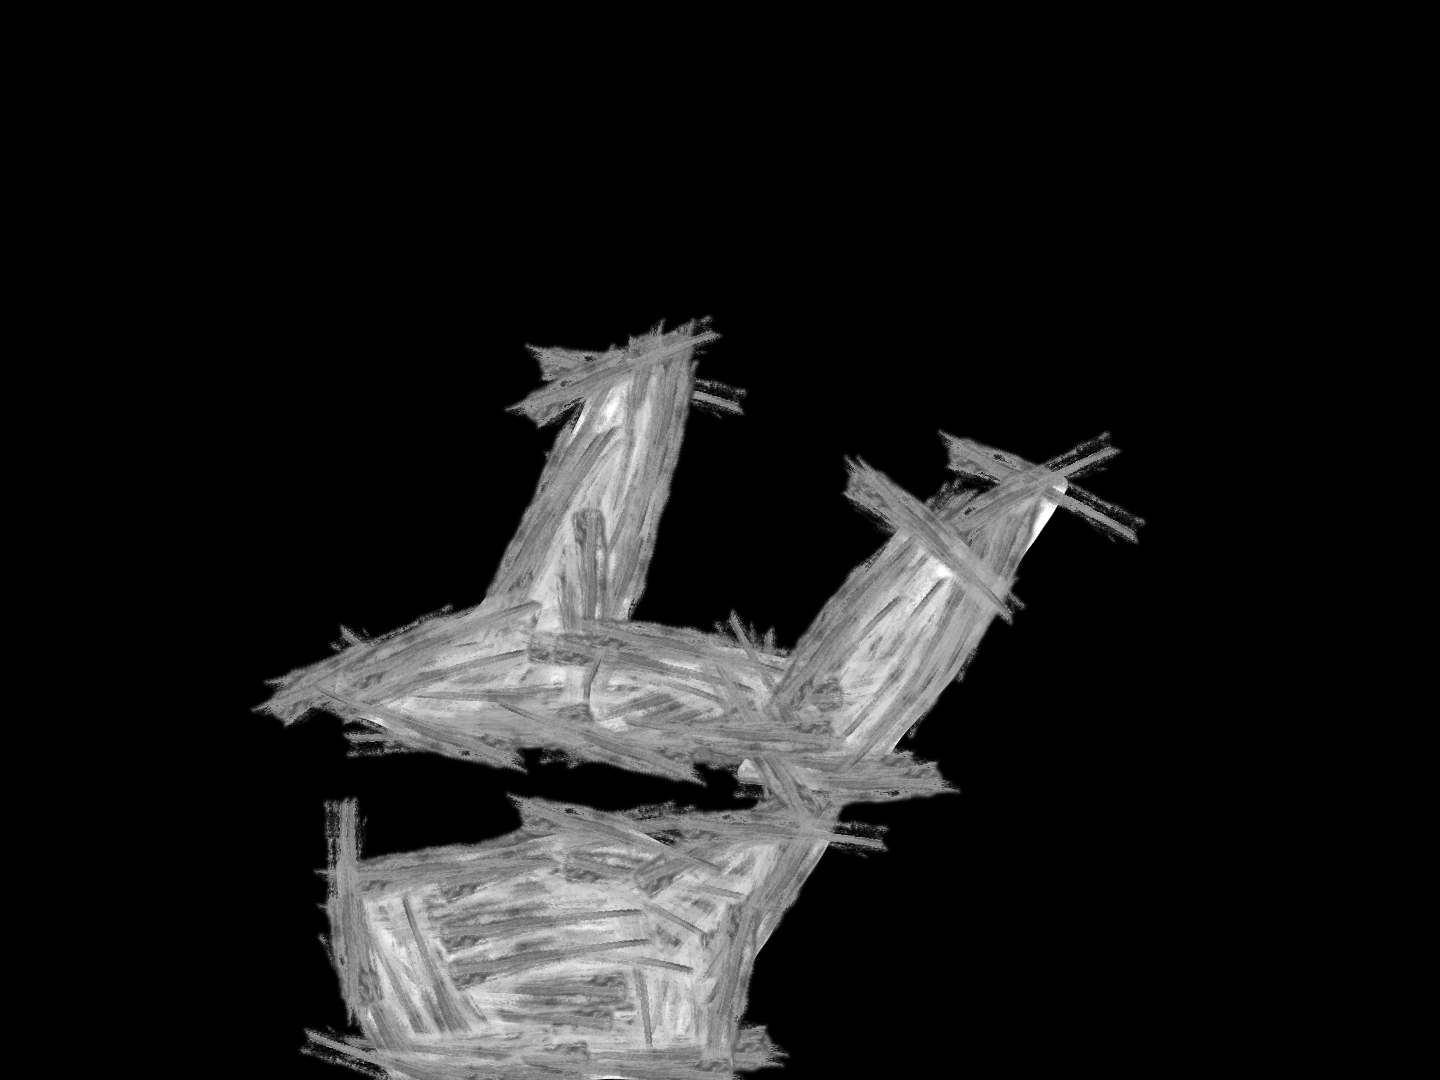

In [71]:
im3 = matte_image.copy()
im3.paste(im_in,(0,0),im_in)
im3.paste(im1,(0,0),im1)
im3.save(tmp_path / f"allC{how_far_in}_{random_count}_{keep_threshold}.png")
im3